In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import torch as t
import numpy as np
from torch.distributions import Categorical, Normal, Independent, MixtureSameFamily
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm, trange

# Super-Sample from Herding

Reproduction of the [paper](https://arxiv.org/abs/1203.3472) "Super-Sample from Herding"


Kernelized herding procedure:
$$
\vec{x}_{t + 1} = \mathop{argmax}_{\vec{x} \sim \mathcal{X}} \langle \vec{w}_t, \vec{x} \rangle \\
\vec{w}_{t + 1} = \vec{w}_t + \mathbb{E}_{\vec{x} \sim p} \left[ \vec{\phi}(\vec{x}) \right] - \vec{\phi}(\vec{x}).
$$

Auxilliary and visualization functions

In [3]:
def create_mixture(n_components: int, n_dims: int):
    mix = Categorical(t.rand(n_components,))
    comp = Independent(Normal(t.rand(n_components, n_dims) * 30 - 15, 1 + t.randn(n_components, n_dims).exp()), 1)
    return MixtureSameFamily(mix, comp)


def to_numpy(tensor: t.Tensor):
    return tensor.detach().cpu().numpy()


def to_tensor(array: np.ndarray):
    return t.tensor(array).cuda().float()


def contour_plot(distribution):
    V = 25
    xs = t.linspace(-V, V)
    ys = t.linspace(-V, V)
    XY = t.stack(t.meshgrid(xs, ys), -1)
    probs = mixture.log_prob(XY).exp()
    plt.contour(to_numpy(XY[:, :, 0]), to_numpy(XY[:, :, 1]), to_numpy(probs), levels=40, zorder=0)

Implementation of Gaussian kernel

In [4]:
class GaussianKernel:
    def __init__(self, sigma: float = 1.):
        self.sigma = sigma
        
    def __call__(self, x1, x2):
        return (-.5 * t.norm(x1[:, None, :] - x2[None, :, :], dim=-1)**2 / self.sigma**2).exp()
    
    def exact_expectation(self, xs: t.Tensor, mixture):
        probs = mixture._mixture_distribution.probs.cuda()
        mus = mixture._component_distribution.base_dist.loc.cuda()
        sigmas = mixture._component_distribution.base_dist.scale.cuda()

        xs = xs[:, None, :]
        mus = mus[None, :, :]
        sigmas = sigmas[None, :, :]
        
        mu = None
        sigma = None
        
        x0 = None
        var = (sigmas**2 * self.sigma**2) / (sigmas**2 + self.sigma**2)
        y0 = -((sigmas**2 * xs + self.sigma**2 * mus)**2 - (sigmas**2 + self.sigma**2) * (sigmas**2 * xs**2 + self.sigma**2  * mus**2)) / (sigmas**2 + self.sigma**2)

        pred_kernel_exp = t.exp(-.5 * y0 / (sigmas**2 * self.sigma**2)) * t.sqrt(var) / sigmas
        
        return (pred_kernel_exp.prod(-1) * probs[None, :]).sum(-1)

Herding procedure with initial gues from some sample pool and subsequent additional optimization with exact calculation of expectation.

In [5]:
def herd_with_exact_exp(
    pool: t.Tensor, init: t.Tensor, kernel_expects: t.Tensor, kernel, n_samples: int, n_opt_steps: int, mixture
):
    second_term = kernel(pool, init).sum(1)
    
    for i in trange(len(init), n_samples, leave=False, desc='herd'):
        loss = kernel_expects - second_term / (i + 1)
        
        x_guess = t.nn.Parameter(pool[t.argmax(loss)][None])
        opt = t.optim.SGD([x_guess], lr=1)
        
        for _ in range(n_opt_steps):
            loss = kernel.exact_expectation(x_guess, mixture) - kernel(x_guess, init).sum(-1) / (i + 1)
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        x_guess = x_guess.detach()
        
        init = t.cat([init, x_guess], 0)
        second_term = second_term + kernel(pool, x_guess).squeeze(1)
    
    return init

# Toy Example

In [6]:
t.manual_seed(19)
np.random.seed(19)

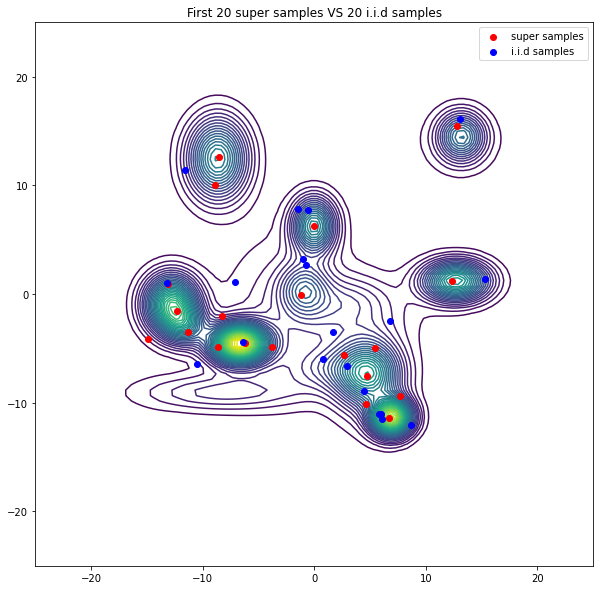

In [7]:
mixture = create_mixture(20, 2)
kernel = GaussianKernel(1)
init = mixture.sample([3]).cuda()
pool = mixture.sample([1024]).cuda()

herded = herd_with_exact_exp(pool, init, kernel.exact_expectation(pool, mixture), kernel, 30, 3, mixture)

plt.figure(figsize=(10, 10))
contour_plot(mixture)
plt.scatter(*to_numpy(herded[:20]).T, c='r', label='super samples', zorder=1)
plt.scatter(*to_numpy(pool[:20]).T, c='b', label='i.i.d samples', zorder=1)
plt.title('First 20 super samples VS 20 i.i.d samples')
plt.legend()
plt.show()

# Imperical Distribution Matching

5D gaussian mixture

$\mathcal{D} = 10^5$ i.i.d samples -- imperical distribution

4 test functions

In [8]:
t.manual_seed(19)
np.random.seed(19)

Herding proceduer with sample pool as empirical distribution (so, no need to additional optimization and expectation is just average over the sample pool)

In [9]:
def herd(pool: t.Tensor, init: t.Tensor, kernel_expects: t.Tensor, kernel, n_samples: int):
    is_taken = t.zeros(len(pool), dtype=t.bool, device=pool.device)
    history = []
    second_term = kernel(pool, init).sum(1)
    
    for i in trange(len(init), n_samples, leave=False, desc='herd'):
        loss = kernel_expects - second_term / (i + 1)
        masked = t.where(is_taken, t.full_like(loss, -np.inf, device=loss.device), loss)
        best_ind = t.argmax(masked)
        
        is_taken[best_ind] = True
        history.append(best_ind)
        second_term = second_term + kernel(pool, pool[best_ind][None]).squeeze(1)
    
    history = t.tensor(history)
    herded = t.cat([init, pool[history]], 0)
        
    return herded


def impirical_kernel_expectation(pool: t.Tensor, kernel, memory_limit: int = 2**22):
    batch_sz = memory_limit // len(pool)
    result = t.zeros(len(pool), device=pool.device)
    for i in trange(0, len(pool), batch_sz, leave=False, desc='kernel expectation'):
        result[i : i + batch_sz] = kernel(pool[i : i + batch_sz], pool).mean(1)
    return result

#### Test statistics

Implementation of all four test functions (three first moments and sine function)

In [10]:
class Moment:
    def __init__(self, p):
        self.p = p
        
    @property
    def name(self):
        return f'$\phi(x) = x^{self.p}$'
        
    def __call__(self, Xs):
        return Xs**self.p
    
    def true(self, mixture):
        probs = mixture._mixture_distribution.probs[:, None]
        mus = mixture._component_distribution.base_dist.loc
        sigmas = mixture._component_distribution.base_dist.scale
        
        if self.p == 1:
            components = mus
        elif self.p == 2:
            components = mus**2 + sigmas**2
        elif self.p == 3:
            components = mus**3 + 3 * mus * sigmas**2
        else:
            raise ValueError(f"Illegal moment {self.p}")
            
        return (probs * components).sum(0)
    
    
class Sin:
    def __call__(self, Xs):
        return t.sin(Xs)
    
    @property
    def name(self):
        return f'$\phi(x) = \sin(x)$'

    
    def true(self, mixture):
        probs = mixture._mixture_distribution.probs[:, None]
        mus = mixture._component_distribution.base_dist.loc
        sigmas = mixture._component_distribution.base_dist.scale

        components = t.sin(mus) * t.exp(-sigmas**2 / 2)
        
        return (probs * components).sum(0)

    
def error(true, pred):
    return (t.norm(true - pred)**2 / len(true))


def cumulative_error(true, pred):
    cum_mean = t.cumsum(pred, dim=0) / (1 + t.arange(len(pred), device=pred.device))[:, None]
    return (t.norm(cum_mean - true[None, :], dim=1)**2 / len(true))**.5

In [11]:
def evaluate_on_function(mixture, D, herded, function, ax, *, plot_D_error):
    true_p = function.true(mixture).cuda()
    true_D = function(D).mean(0)
    
    N_IID_P = 100
    iid_p = t.zeros(N_IID_P, len(herded), device=herded.device)
    for i in trange(N_IID_P, desc='iid on p', leave=False):
        iid_p[i, :] = cumulative_error(true_p, function(mixture.sample([len(herded)]).cuda()))
        
    iid_p_np = to_numpy(iid_p)
    inds = 2**np.arange(0, int(np.log2(len(herded)))) - 1
    subvalues = iid_p_np[:, inds]

    ys = subvalues.mean(0)
    y_err_up = ys - np.quantile(subvalues, 0.9, axis=0)
    y_err_low = np.quantile(subvalues, 0.1, axis=0) - ys
    ax.errorbar(inds, ys, np.stack([y_err_up, y_err_low], 0), c='g', label='Random sampling')

    ax.plot(to_numpy(cumulative_error(true_p, function(herded))), label='Hearding, erro on p', c='r')
    if plot_D_error:
        ax.plot(to_numpy(cumulative_error(true_D, function(herded))), label='Hearding, erro on $\mathcal{D}$', c='b')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(function.name)

Randomly initialize Gaussian Mixture model and sample dataset $\mathcal{D}$

In [12]:
mixture = create_mixture(20, 3)
D = mixture.sample([10**5]).cuda()
FUNCTIONS = [Moment(i) for i in range(1, 4)] + [Sin()]

## Exact

Experiment of matching the true distribution

In [13]:
kernel = GaussianKernel(np.sqrt(10))
init = mixture.sample([3]).cuda()

herded_exact = herd_with_exact_exp(D, init, kernel.exact_expectation(D, mixture), kernel, 10**4, 3, mixture)

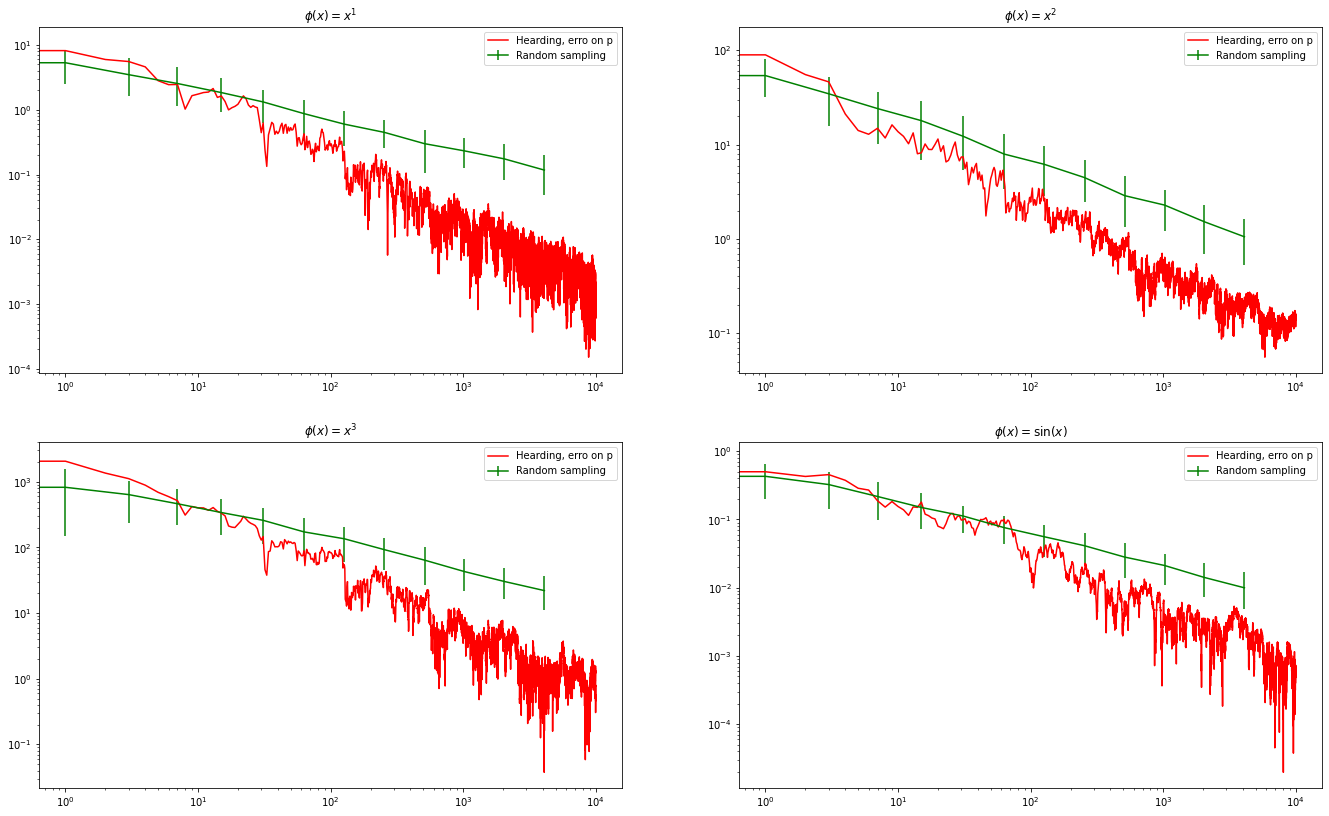

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(23, 14))
axs = axs.flatten()

for i, function in enumerate(FUNCTIONS):
    evaluate_on_function(mixture, D, herded_exact, function, axs[i], plot_D_error=False)

## Empirical

Experiment of matching the empirical distribution

In [15]:
kernel = GaussianKernel(np.sqrt(10))
init = mixture.sample([3]).cuda()

herded = herd(D, init, impirical_kernel_expectation(D, kernel), kernel, 10**5 // 2)

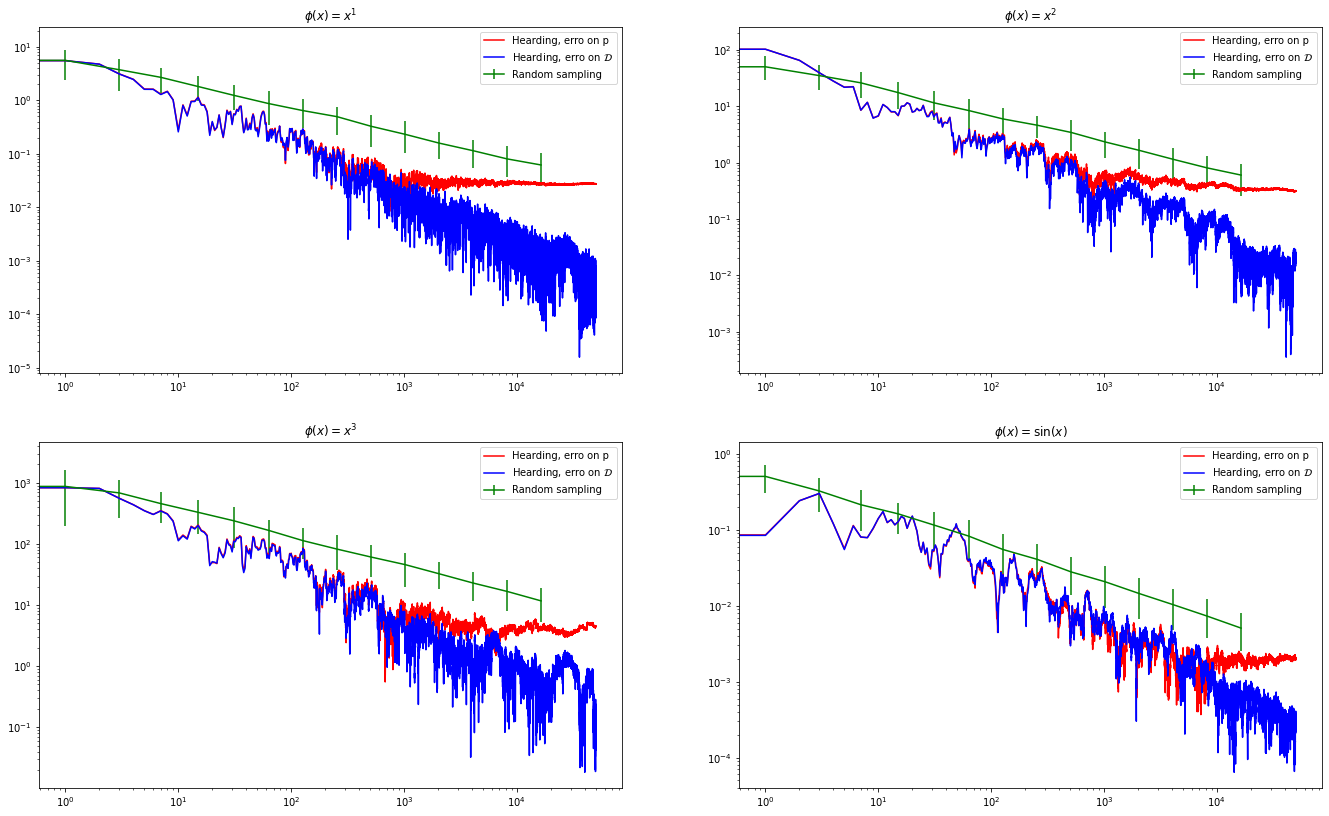

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(23, 14))
axs = axs.flatten()

for i, function in enumerate(FUNCTIONS):
    evaluate_on_function(mixture, D, herded, function, axs[i], plot_D_error=True)

## Low scale Gaussian kernel failure

Example of bad hyperparameters of kernel and its influence on herding approximation quality

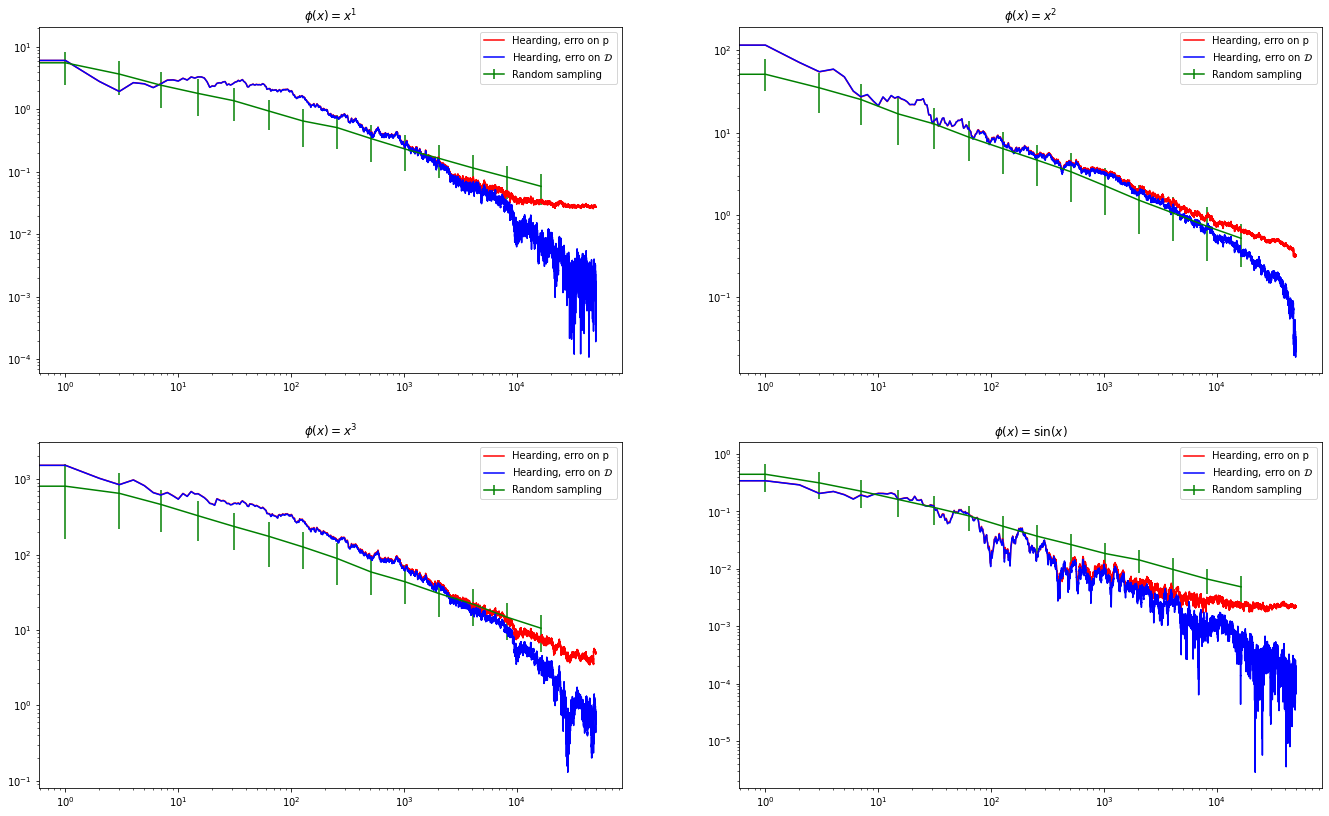

In [17]:
kernel = GaussianKernel(1)
init = mixture.sample([3]).cuda()

herded = herd(D, init, impirical_kernel_expectation(D, kernel), kernel, 10**5 // 2)

FUNCTIONS = [Moment(i) for i in range(1, 4)] + [Sin()]

fig, axs = plt.subplots(2, 2, figsize=(23, 14))
axs = axs.flatten()

for i, function in enumerate(FUNCTIONS):
    evaluate_on_function(mixture, D, herded, function, axs[i], plot_D_error=True)

#### Bayesian Posterior

Experiment of approximating the Bayesian posterior.

1. UCI spambase (4601 samples, 3000 to train, 1601 to test, 57 features)
2. Whiten with PCA
3. Log regression with gaussian prior
4. Metropolis hasting with gaussian proposal $10^7$ models
5. Subsample with a factor of 100 (resulting in $10^5$ samples) = $D$
6. Whiten with PCA
7. Herd with Gaussian kernel with $\sigma = 10$ = $S_T$ (here $T$ is the number of supersamples)

$$
RMSE(S_T, D) = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{1}{T} \sum_{t=1}^{T} p(y_n | x_n, \theta_t) - \frac{1}{|D|} \sum_{d=1}^{|D|} p(y_n | x_n, \theta_d \right]
$$


8. Compare RMSE of $S_T$ and bootstrapped $D$ with the same size

In [18]:
t.manual_seed(19)
np.random.seed(19)

### Data preparation

In [19]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts


def load_data():
    data = pd.read_csv('./data/spambase.data', header=None)
    data_np = np.array(data)
    X, y = data_np[:, :-1], data_np[:, -1]

    X = PCA().fit_transform(X)

    X_train, X_test, y_train, y_test = tts(X, y, train_size=3000)

    X_train = t.tensor(X_train).cuda().float()
    X_test = t.tensor(X_test).cuda().float()
    y_train = t.tensor(y_train).cuda().float()
    y_test = t.tensor(y_test).cuda().float()
    
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data()

n_features = X_train.shape[1]

### Probability Model

In [20]:
def vmap_log_p(X: t.tensor, thetas: t.Tensor, both: bool = False):
    prod = t.matmul(X, thetas.T)
    if both:
        return t.nn.functional.logsigmoid(prod), t.nn.functional.logsigmoid(-prod)
    else:
        return t.nn.functional.logsigmoid(prod)

    
def batched_mean_log_p(X: t.tensor, thetas: t.Tensor, batch_sz: int = 2**10):
    result = t.zeros(X.shape[0], device=X.device)
    for i in trange(0, len(X), batch_sz, desc='log_p prediction', leave=False):
        predictions = vmap_log_p(X[i:i + batch_sz], thetas)
        print(predictions.shape)
        result[i:i + batch_sz] = (t.logsumexp(predictions, dim=1) - np.log(predictions.shape[1])).exp()
    return result

    
def vmap_prior(thetas: t.Tensor):
    return -.5 * t.norm(thetas, dim=1)**2
    
    
class LogistiRegressionPosterior:
    def __init__(self, X: t.Tensor, y: t.Tensor):
        self.X = X
        self.y = y
        
    def log_prob(self, theta: t.Tensor):
        log_prob_1, log_prob_0 = vmap_log_p(self.X, theta, both=True)
        LL = (self.y[:, None] * log_prob_1 + (1 - self.y)[:, None] * log_prob_0).sum(0)
        prior = vmap_prior(theta)
        return LL + prior

In [21]:
lrp = LogistiRegressionPosterior(X_train, y_train)

### Maximum A Posteriori

698.6973876953125


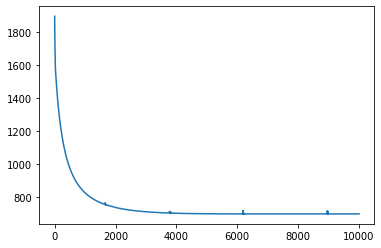

In [22]:
def minimize(posterior, n_steps: int):
    theta = t.nn.Parameter(t.randn(posterior.X.shape[1]).cuda() * 1e-3)
    optimizer = t.optim.Adam([theta], lr=1e-3)
    
    losses = []
    for _ in trange(n_steps, desc='minimization', leave=False):
        loss = -posterior.log_prob(theta[None]).squeeze(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
    plt.plot(losses)
    print(losses[-1])
        
    return theta.detach().clone(), losses

theta_map, losses = minimize(lrp, 10000)

### Metropolis-Hastings Sampler

In [23]:
class MetropolisHastings:
    def __init__(
        self,
        target, 
        proposal_sigma: t.Tensor
    ):
        self.target = target
        self.proposal = t.distributions.Normal(t.zeros_like(proposal_sigma), proposal_sigma)
        
    def sample(self, init: t.Tensor, n_steps: int):
        chain = t.zeros(n_steps, *init.shape)
        target_prob = self.target.log_prob(init)
        
        accepted = t.zeros(len(init), dtype=t.int)
        
        for step in trange(n_steps, desc='sampling', leave=False):
            prop = init + self.proposal.sample([len(init)])
            prop_prob = self.target.log_prob(prop)
            
            flag = t.rand(len(init)).cuda().log() < prop_prob - target_prob
            
            init = t.where(flag[:, None], prop, init)
            target_prob = t.where(flag, prop_prob, target_prob)

            accepted += flag.cpu()
            chain[step] = init
            
        return chain, to_numpy(accepted) / n_steps
    
    
def subsample_chain(chain: t.Tensor, n_samples: int):
    samples = chain.reshape(-1, chain.shape[-1])
    perm = t.randperm(len(samples))
    return samples[perm[:n_samples]]

#### Sampling $\mathcal{D}$

In [24]:
sampler = MetropolisHastings(lrp, t.full([n_features], 1e-3).cuda())
chain, acceptance_rate = sampler.sample(theta_map[None].repeat(128, 1), int(2.5 * 10**6))

SuperD = subsample_chain(chain, int(2.5 * 10**6))
D = subsample_chain(chain, 10**5)

Acceptance rate: 0.16573006562499998


In [25]:
def batched_mean_log_p(X, thetas, batch_sz: int = 2**4):
    X = X.cpu().double()
    thetas = thetas.cpu().double()
    
    result = t.zeros(len(X))
    for i in trange(0, len(X), batch_sz, desc='batched mean log p', leave=False):
        result[i : i + batch_sz] = vmap_log_p(X[i : i + batch_sz], thetas).exp().mean(1)
    
    return result.cuda()

In [26]:
predictions_D = batched_mean_log_p(X_test, D)
predictions_super_D = batched_mean_log_p(X_test, SuperD)

### Whitened herding

Herding algorithm is applied to the data whitened by PCA. It is equivalent to applying herding with non-isotropic Gaussian kernel whose covariance matrix is a multiple of the covariance matrix of $\mathcal{D}$

In [27]:
pca = PCA().fit(to_numpy(D))
whitened_D = to_tensor(pca.transform(to_numpy(D)))

kernel = GaussianKernel(np.sqrt(10))
whitened_herded = herd(
    whitened_D, 
    whitened_D[t.randint(0, len(whitened_D), [2])], 
    impirical_kernel_expectation(whitened_D, kernel),
    kernel,
    10**5 // 2,
)

herded = to_tensor(pca.inverse_transform(to_numpy(whitened_herded)))

### Evaluation

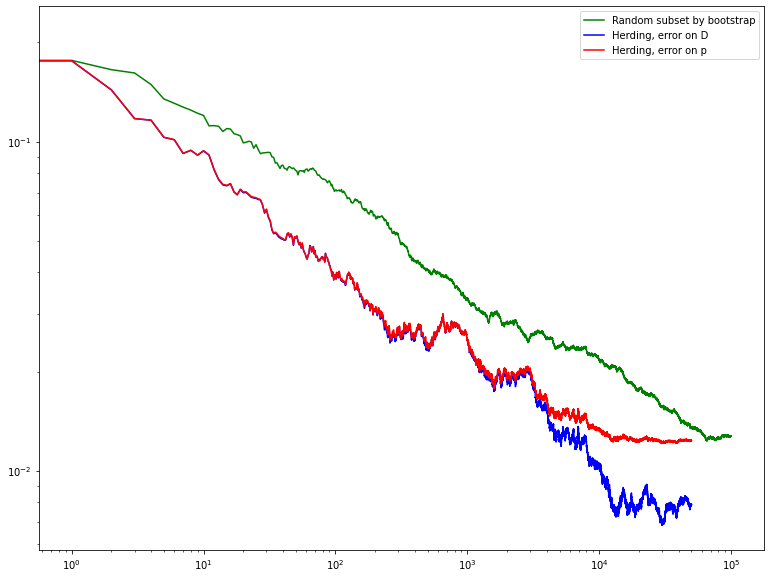

In [30]:
plt.figure(figsize=(13, 10))

shuffled = D[t.randint(0, len(D), [len(D)])]
predictions_shuffled = vmap_log_p(X_test.cpu(), shuffled.cpu()).exp().cuda()
plt.plot(
    to_numpy(cumulative_error(predictions_D, predictions_shuffled.T)**.5), 
    c='g', label='Random subset by bootstrap'
)

predictions_herded = vmap_log_p(X_test.cpu(), herded.cpu()).exp().cuda()
plt.plot(
    to_numpy(cumulative_error(predictions_D, predictions_herded.T)**.5),
    c='b', label='Herding, error on D'
)
plt.plot(
    to_numpy(cumulative_error(predictions_super_D, predictions_herded.T)**.5), 
    c='r', label='Herding, error on p'
)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()